# VAE (not nan with 100 epochs and latent space 200)

In [5]:
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import moviepy.editor as mp
import numpy as np
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [8]:
ds = image_dataset_from_directory('zelle', label_mode=None, image_size=(448, 448), batch_size=16)

Found 273 files belonging to 1 classes.


In [9]:
ds = ds.map(lambda x: x/255)
# ds = ds.map(lambda x: (x, x))

In [10]:
imgs = ds.as_numpy_iterator().__next__()

In [11]:
imgs.shape

(16, 448, 448, 3)

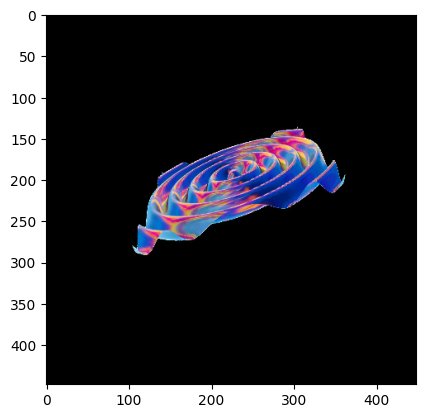

In [12]:
plt.imshow(imgs[0])


In [13]:
X_train = ds.map(lambda x : x/255).batch(16).prefetch(tf.data.AUTOTUNE)

In [14]:
from keras.layers import Lambda

In [15]:
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Layer

In [16]:
import tensorflow as tf
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [17]:
latent_dim = 200


input_image = Input(shape=(448, 448, 3))
    
x = Conv2D(32, (3, 3), padding='same', activation="relu")(input_image)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
encoder_output = Dense(latent_dim, activation="relu")(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(input_image, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 224, 224, 32  0           ['conv2d[0][0]']                 
                                )                                                           

In [18]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))  
x = Dense(7*7*64, activation='tanh')(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)


    
decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
decoder = Model(inputs=latent_inputs, outputs=decoder_output, name="decoder")
decoder.summary()
    

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              630336    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      1475

In [19]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [20]:
ds

<MapDataset element_spec=TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None)>

In [21]:
#next_images = ds.as_numpy_iterator().__next__()

In [22]:
#vae.decoder(vae.encoder(next_images[0].reshape(-1,448,448,3))[0])

In [23]:
class CallbackSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.model.save_weights(f'/home/jupyter/model_{epoch}')

save_model = CallbackSaveModel()

In [24]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
#vae.load_weights('model_10')
#vae.fit(ds, epochs=10, callbacks=[save_model])

In [25]:
vae.save_weights('save_model_100epochs_200latdim')

In [26]:
vae.load_weights('model_vae_2500') #load_weights



In [27]:
encoded_images = vae.encoder(imgs[10:12].reshape(-1,448,448,3))
decoded_images = vae.decoder(encoded_images[0])

In [28]:
from tensorflow import keras
#model = keras.models.load_model('model_vae_2500.data-00000-of-00001')

In [29]:
#vae.fit

In [30]:
#prediction = vae.predict(ds, verbose=0)

# Original Image

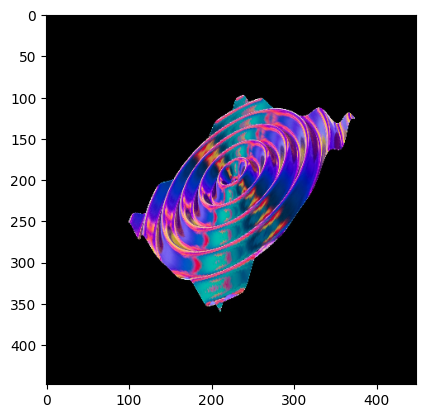

In [31]:
plt.imshow(imgs[5])

# VAE reconstructed image

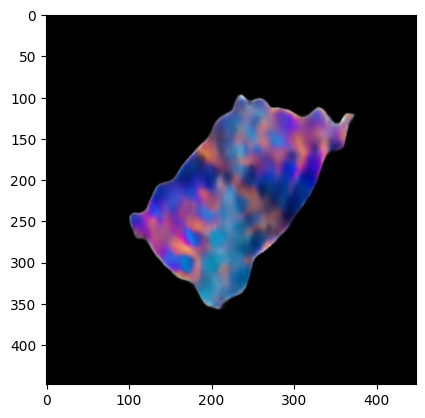

In [32]:
encoded_image = vae.encoder(imgs[5].reshape(-1,448,448,3))
decoded_image = vae.decoder(encoded_image[0])
plt.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))

In [33]:
# for i in range(3):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
#     encoded_image = vae.encoder(imgs[i].reshape(-1,448,448,3))
#     decoded_image = vae.decoder(encoded_image[0])
#     ax2.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))
#     ax1.imshow(imgs[i])

# Audio and video

In [52]:
import librosa
y, sr = librosa.load('Drums.wav')

# How many datapoints are in the onset_envelope array
#len(onset_env)

# calculate desired hop length based on 24 fps
fps = 24
hop_length = int(sr / fps)

# calculate optimal n_fft length based on hop length
n_fft = 2 ** (hop_length - 1).bit_length()

# ENVELOPES WITH HOP LENGTH DETERMINED BY FPS
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length = hop_length, n_fft=n_fft)

#onset_env = librosa.onset.onset_strength(y=y, sr=sr)

onset_frames = librosa.onset.onset_detect(y=y, sr=sr, units='time')
len(onset_frames)

N_STEPS = len(onset_env)

frame_duration = 1/24
audio_movement = []

#image 3 and 1000
# encoded_images = vae.encoder(imgs[10:12].reshape(-1,448,448,3))
# decoded_images = vae.decoder(encoded_images[0])

times = librosa.times_like(onset_env, sr=24)

#onset_env = librosa.onset.onset_strength(y=y, sr=sr)

# The number of datapoints in the envelope is very close to the amount of frames at 24fps in the 8.3 second drum clip, i reckon this is related to how we sync the audio/video/N_steps

In [63]:
N_STEPS
#onset_env

201

In [64]:
audio_time = librosa.get_duration(y=y)
audio_time

8.347845804988662

In [74]:
onset_env.max()

26.55247

In [78]:
onset_env_norm = librosa.util.normalize(onset_env)

In [66]:
start_lat_vec, end_lat_vec = encoded_images[0][0], encoded_images[0][1]
start_lat_vec.shape, end_lat_vec.shape

(TensorShape([200]), TensorShape([200]))

In [108]:
print(onset_env_norm + 6)

[6.        6.367743  6.067049  6.028434  6.0423307 6.0289116 6.0407786
 6.0697484 6.0450172 6.060278  6.1898484 6.096075  6.037664  6.2981977
 6.1306176 6.01697   6.0235524 6.0092955 6.0099487 6.030906  6.073408
 6.028606  6.0223613 6.048907  6.0404577 6.0333576 6.473352  6.0137234
 6.0223026 6.49007   6.033108  6.01528   6.390869  6.000824  6.022806
 6.519775  6.0498986 6.0088563 6.7177463 6.0195727 6.0250325 6.0119696
 6.025782  6.0112805 6.0671673 6.0421834 6.0111594 6.430388  6.0644407
 6.1425343 6.21417   6.069307  6.0033646 6.0129724 6.0189166 6.033484
 6.0365987 6.347512  6.015451  6.0170336 6.8142786 6.002671  6.0023293
 7.        6.0060935 6.01284   6.010467  6.028927  6.0084295 6.046517
 6.031078  6.0189743 6.017015  6.0363965 6.0300946 6.030142  6.8306246
 6.0227895 6.0343194 6.4396353 6.0126634 6.000565  6.430272  6.003088
 6.0150743 6.59407   6.0144506 6.0128837 6.717204  6.040736  6.0242424
 6.020246  6.011867  6.008471  6.025659  6.1723366 6.0080733 6.3103523
 6.1870813 

In [109]:
step_vec = (end_lat_vec - start_lat_vec ) / N_STEPS
interpolation_images = []

for i in range(0, N_STEPS):
    interpolation_images.append(start_lat_vec + (i * (step_vec *(onset_env_norm[i] + 1.5))))
    #print(onset_env[i])

interp_array = np.array(interpolation_images)
interp_array.shape
#type(interp_array)


(201, 200)

In [110]:
audio_time = librosa.get_duration(y=y)
# int_1_ms = audio_time*1000
# audio_N_STEPS_ms = 1/frames_per_second * 1000
# step_time = int_1_ms/audio_N_STEPS_ms
# interpolation_images_and_audio = []
# for n in range(0, N_STEPS):
#     audio_movement.append(start_lat_vec + (i * step_vec))
# interp_array = np.array(interpolation_images)
audio_time

8.347845804988662

In [111]:
encoded_images[0].shape

TensorShape([2, 200])

In [112]:
#inter_images_encoded = vae.encoder(interp_array).reshape(-1,448,448,3)
inter_images_decoded = vae.decoder(interp_array)

inter_images = (inter_images_decoded.numpy() * 255).astype('uint8')


In [113]:
inter_images.shape[0]

201

In [114]:
for i in range(inter_images.shape[0]):
    im = Image.fromarray(inter_images[i])
    im.save(f'./images/image_{i}.jpg')

# Load the audio file
audio_clip = mp.AudioFileClip('Drums.wav')

# Define the frame folder where the images are stored
frame_folder = './images'

# Get the list of image paths
im_paths = [os.path.join(frame_folder, f'image_{i}.jpg') for i in range(N_STEPS)]

# Load the images as frames
frames = [mp.ImageClip(image_path).set_duration(0.0416666) # equal to 24fps
          for image_path in im_paths]

# Combine the frames into a video
video_clip = mp.concatenate_videoclips(frames, method='chain')  # experiment with different method values

# Overlay the audio on the video
final_clip = video_clip.set_audio(audio_clip)

# Write the final video to file
final_clip.write_videofile("Aoutput_video.mp4", fps=24) #

Moviepy - Building video Aoutput_video.mp4.
MoviePy - Writing audio in Aoutput_videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video Aoutput_video.mp4



Moviepy - Done !
Moviepy - video ready Aoutput_video.mp4


In [48]:
#pip freeze

In [49]:
#pip install ffmpeg --upgrade

In [47]:
# # Generate a series of points in the latent space
# interp_latent = start_lat_vec + (np.arange(N_STEPS)[:, np.newaxis] * step_lat_vec)


# # Generate images corresponding to each interpolated point
# inter_images = []
# for i in range(N_STEPS):
#     # Calculate onset envelope factor
#     onset_factor = onset_env[int(i * frame_per_second)] / onset_env.max()

#     # Modify step vector in the latent space using onset factor
#     mod_step_lat_vec = step_lat_vec * onset_factor

#     # Calculate interpolated point in the latent space using modified step vector
#     interp_latent_i = start_lat_vec + (i * mod_step_lat_vec)

#     # Decode interpolated point into image
#     interp_image_i = vae.decoder.predict(np.array([interp_latent_i]))

#     # Convert image to uint8 format
#     interp_image_i = (interp_image_i * 255).astype('uint8')

#     inter_images.append(interp_image_i)
